In [ ]:
!unzip /content/drive/MyDrive/VDL/VDL/exercise_3/bags_data.zip

In [ ]:
pip install torchfcn

In [ ]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import shutil
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from PIL.Image import NEAREST
from torchvision import transforms 
import torchfcn
import numpy as np

path="bags_data"


class BagDataset(Dataset):
  def __init__(self, path, split):
    self.path = path
    self.split=split
    self.class_names = ["bg", "bag"]
    self.mean_bgr = np.array([127.60694514, 133.22079374, 149.47072998])

    with open(os.path.join(self.path, "imagesets", self.split + ".txt"), "r") as fp:
      self.ids = fp.read().splitlines()

    """
    mean=[]
    for id in self.ids:
      img = Image.open(os.path.join(self.path, "JPEGImages", id+".jpg")).resize((200,200), resample=NEAREST)
      img = np.array(img, dtype=np.uint8)
      img = img[:, :, ::-1]
      mean.append(np.mean(img, axis=(0,1)))
    print(np.mean(np.array(mean),axis=0))
    """

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
    img = Image.open(os.path.join(self.path, "JPEGImages", self.ids[idx]+".jpg")).resize((256,256), resample=NEAREST)
    img = np.array(img, dtype=np.uint8)
    mask = Image.open(os.path.join(self.path, "segmentation_mask", self.ids[idx]+".png")).resize((256,256), resample=NEAREST)
    mask = np.array(mask, dtype=np.int32)

    return self.transform(img, mask)

  def transform(self, img, lbl):
      img = img[:, :, ::-1]  # RGB -> BGR
      img = img.astype(np.float64)
      img -= self.mean_bgr
      img = img.transpose(2, 0, 1)
      img = torch.from_numpy(img).float()
      lbl = torch.from_numpy(lbl).long()
      return img, lbl

  def untransform(self, img, lbl):
      img = img.numpy()
      img = img.transpose(1, 2, 0)
      img += self.mean_bgr
      img = img.astype(np.uint8)
      img = img[:, :, ::-1]
      lbl = lbl.numpy()
      return img, lbl

train_loader = DataLoader(BagDataset(path, "train"), shuffle=True, batch_size=1, num_workers=2)
val_loader = DataLoader(BagDataset(path, "val"), batch_size=1, num_workers=2)

In [ ]:
def get_parameters(model, bias=False):
    import torch.nn as nn
    modules_skipped = (
        nn.ReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.Sequential,
        torchfcn.models.FCN32s,
        torchfcn.models.FCN16s,
        torchfcn.models.FCN8s,
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None
        elif isinstance(m, modules_skipped):
            continue
        else:
            raise ValueError('Unexpected module: %s' % str(m))

In [ ]:
cuda = torch.cuda.is_available()

model = torchfcn.models.FCN32s(n_class=2)

vgg16 = torchfcn.models.VGG16(pretrained=True)
model.copy_params_from_vgg16(vgg16)
model = model.cuda()

lr=1.0e-10

optimizer = torch.optim.SGD(
        [
            {'params': get_parameters(model, bias=False)},
            {'params': get_parameters(model, bias=True),
             'lr': lr * 2, 'weight_decay': 0},
        ],
        lr=lr,
        momentum=0.99,
        weight_decay=0.0005)
 
 
trainer = torchfcn.Trainer(cuda, model, optimizer, train_loader, val_loader, "/content/drive/MyDrive/VDL/VDL/exercise_3/out_8", 427*20+1, interval_validate=427*4)
trainer.train()

In [ ]:
import csv
from collections import defaultdict

with open("/content/drive/MyDrive/VDL/VDL/exercise_3/out_8/log.csv", "r") as fp:
  reader = csv.reader(fp)
  train_iou=defaultdict(lambda: [])
  for row in reader:
    if row[2] == '':
      print("Epoch", row[0], "val mean_iou", row[10])
    elif row[7] == '':
      train_iou[row[0]].append(row[5])
      
  print()
  for e, l in train_iou.items():
    mean = np.mean(np.asarray(l).astype(np.float))
    print("Epoch", e, "train mean_iou", mean)

Epoch 0 val mean_iou 0.315237954398182
Epoch 4 val mean_iou 0.8250588521738385
Epoch 8 val mean_iou 0.8608750073886949
Epoch 12 val mean_iou 0.8701964669945421
Epoch 16 val mean_iou 0.8751256032363535
Epoch 20 val mean_iou 0.8799901709881028

Epoch 0 train mean_iou 0.5753471883153924
Epoch 1 train mean_iou 0.7415007674913048
Epoch 2 train mean_iou 0.7928438520633025
Epoch 3 train mean_iou 0.8195198636557165
Epoch 4 train mean_iou 0.8308646804959566
Epoch 5 train mean_iou 0.842087453475256
Epoch 6 train mean_iou 0.8505985254800937
Epoch 7 train mean_iou 0.857545106029095
Epoch 8 train mean_iou 0.8634660653307672
Epoch 9 train mean_iou 0.8648341241118104
Epoch 10 train mean_iou 0.8704847395275911
Epoch 11 train mean_iou 0.8733521624167858
Epoch 12 train mean_iou 0.8769099711247831
Epoch 13 train mean_iou 0.8776992574536674
Epoch 14 train mean_iou 0.8825336665021721
Epoch 15 train mean_iou 0.8833107996766926
Epoch 16 train mean_iou 0.8847147620123252
Epoch 17 train mean_iou 0.885432036977

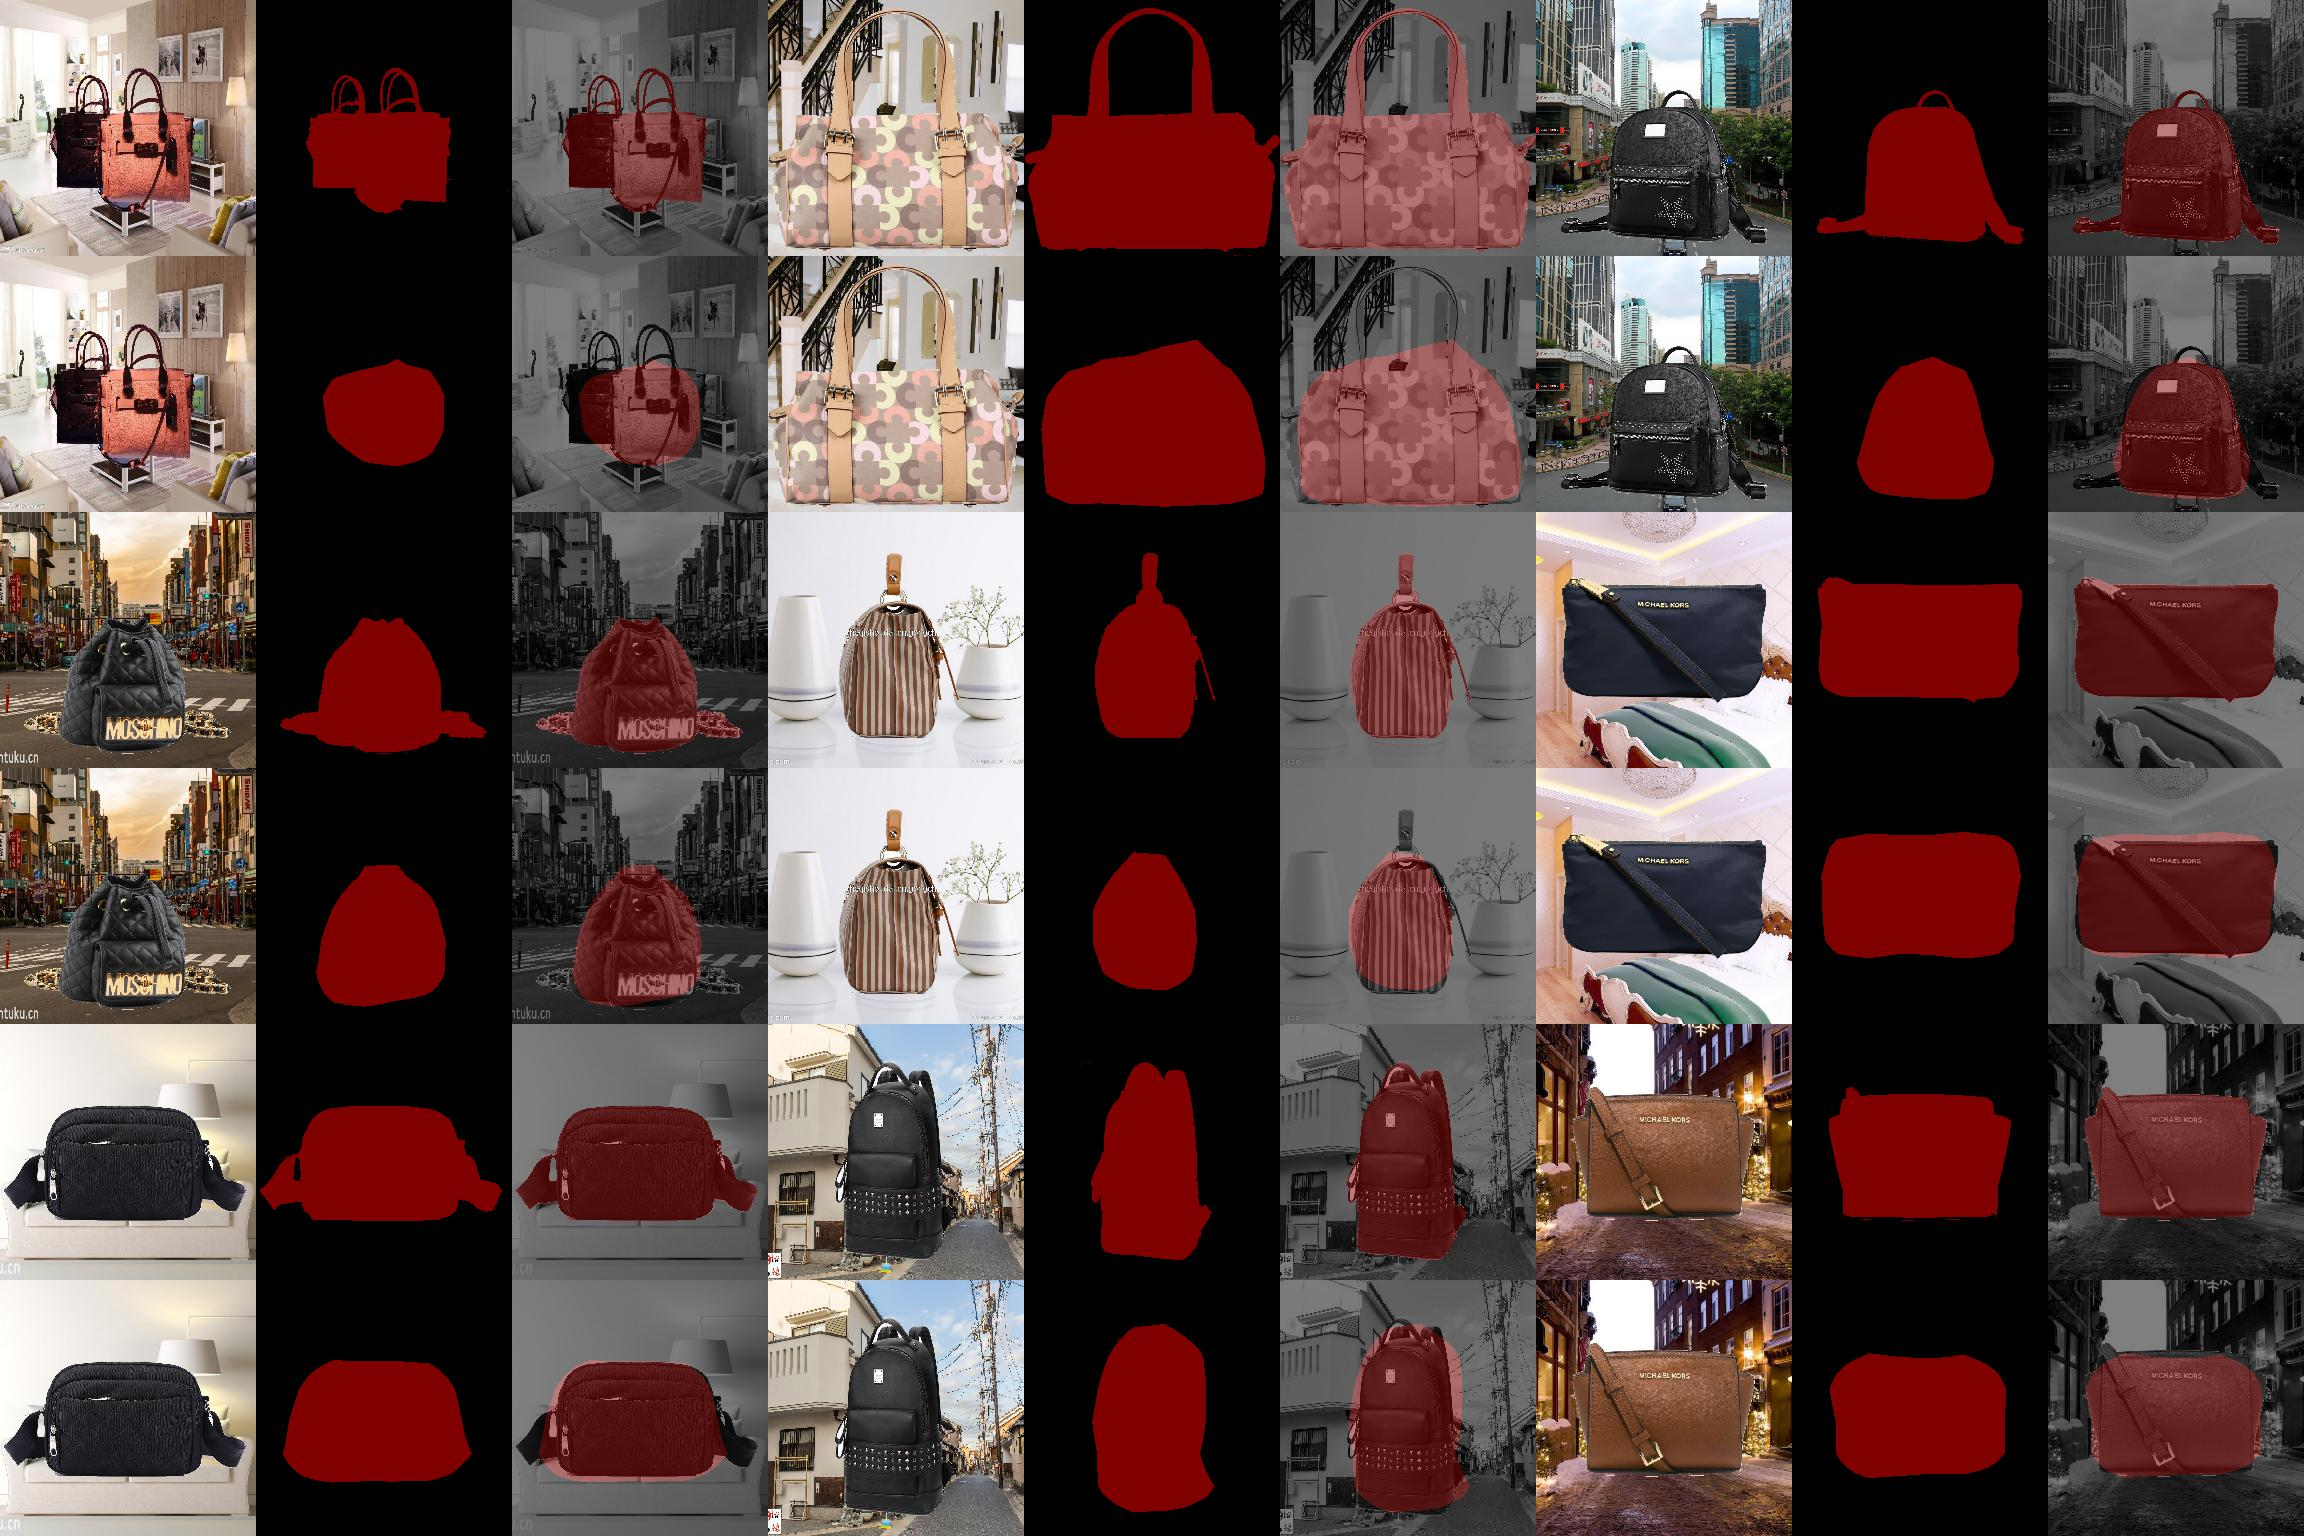